
# 图像分类

使用 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图像进行分类。数据集中图片的内容包括飞机（airplane）、狗（dogs）、猫（cats）及其他物体。

## 下载数据

 [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [1:13:16, 38.8KB/s]                             


All files found!


## 探索数据集


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 22:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


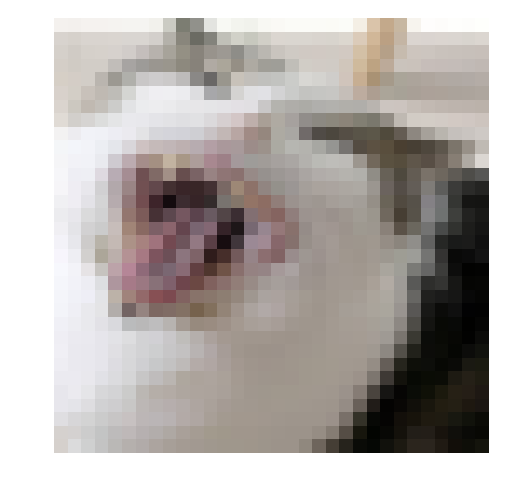

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 4
sample_id =22
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 图像预处理
### 正规化

In [3]:
def normalize(x):
    y=(x-x.min())/(x.max()-x.min())       
    return y


### One-hot 编码

In [4]:
from sklearn import preprocessing

m = np.zeros(10)
def one_hot_encode(x):

    global m
    y=[] 
    if m.all():
        print(1)
    else:
        lb = preprocessing.LabelBinarizer()
        m=lb.fit_transform([0,1,2,3,4,5,6,7,8,9])
    for i in x:
        y.append(m[i])
    return np.array(y)

## 预处理并保存


In [5]:
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## checkpoint

In [6]:

import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## 搭建神经网络

In [7]:
import tensorflow as tf


def neural_net_image_input(image_shape):
    l1=list(image_shape)
    l1.insert(0,None)
    x=tf.placeholder(dtype=tf.float32,shape=l1,name='x')
    return x


def neural_net_label_input(n_classes):

    y=tf.placeholder(dtype=tf.int32,shape=(None,n_classes),name='y')
    
    return y


def neural_net_keep_prob_input():

    keep_prob=tf.placeholder(dtype=tf.float32,name='keep_prob')
    
    return keep_prob


### 卷积-最大池（Convolution and Max Pooling）化层


In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):

#     print (x_tensor)
#     print (conv_ksize)
#     print (conv_num_outputs)
#     print (pool_ksize)
#     print (pool_strides)
    
    k_output = conv_num_outputs
    
    # Image Properties
    image_width =int(x_tensor.shape[1])
    image_height = int(x_tensor.shape[2])
    color_channels = int(x_tensor.shape[3])

    # Convolution filter
    filter_size_width = conv_ksize[0]
    filter_size_height = conv_ksize[1]
    
    filter_stride_width = conv_strides[0]
    filter_stride_height = conv_strides[1]
    
    k_output=conv_num_outputs
    
    weight = tf.Variable(tf.truncated_normal([filter_size_height, filter_size_width, color_channels, k_output],stddev=0.01))
    
    bias = tf.Variable(tf.zeros(k_output))
    
#     print ('weight end')
    
    # Apply Convolution
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, filter_stride_height, filter_stride_width, 1], padding='SAME')
    # Add bias
#     print ('conv end')
    
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    pool_size_width = pool_ksize[0]
    pool_size_height = pool_ksize[1]
    
    pool_stride_width = pool_strides[0]
    pool_stride_height = pool_strides[1]
    
    
    pool_layer = tf.nn.max_pool(
    conv_layer,
    ksize=[1,pool_size_height, pool_size_width, 1],
    strides=[1, pool_stride_height, pool_stride_width,1],
    padding='SAME')

#     print (pool_layer)    

    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    
    return pool_layer
    

### 展开层

In [9]:
def flatten(x_tensor):
    return tf.layers.flatten(x_tensor)

### 全连接层

In [10]:
def fully_conn(x_tensor, num_outputs):

    weight=tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]),num_outputs],stddev=0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    return  tf.nn.relu(tf.matmul(x_tensor,weight)+bias)


### 输出层

In [11]:
def output(x_tensor, num_outputs):

    weight=tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]),num_outputs],stddev=0.01))
    bias = tf.Variable(tf.zeros(num_outputs))

    return tf.matmul(x_tensor,weight)+bias


### 创建卷积模型

In [12]:
def conv_net(x, keep_prob):
    
    conv_num_outputs1=64;
    conv_num_outputs2=128;
    conv_num_outputs3=256;
    
    conv_ksize=(4,4)
    conv_ksize2=(3,3)
    conv_ksize3=(2,2)
    
    conv_strides=(1,1)
    conv_strides2=(1,1)
    conv_strides3=(1,1)
    
    pool_ksize=(3,3)
    
    pool_strides=(2,2)
    
    x=tf.cast(x,tf.float32)

    #三层卷积层
    x = conv2d_maxpool(x,conv_num_outputs1,conv_ksize,conv_strides,pool_ksize,pool_strides)
    x = conv2d_maxpool(x,conv_num_outputs2,conv_ksize2,conv_strides2,pool_ksize,pool_strides)
    x = conv2d_maxpool(x,conv_num_outputs3,conv_ksize3,conv_strides3,pool_ksize,pool_strides)
   

    x=flatten(x)
    x=fully_conn(x,1024)
    
    #dropout
    x=tf.nn.dropout(x,keep_prob=keep_prob)
    
    x=fully_conn(x,512)
    
    #dropout
    x=tf.nn.dropout(x,keep_prob=keep_prob)
    x=output(x,10)
    return x


tf.reset_default_graph()


# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)

keep_prob = neural_net_keep_prob_input()


# Model
logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits')


# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)


# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## 训练该神经网络

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):

    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
    

### 显示状态

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):


    # Loss and Optimizer
    train_feed_dict = {x: feature_batch, y: label_batch,keep_prob:1.0}
    valid_feed_dict = {x: valid_features, y: valid_labels,keep_prob:1.0}
    
    print(session.run(cost,feed_dict=train_feed_dict))
    print(session.run(accuracy,feed_dict=valid_feed_dict))
    

### 超参数

In [15]:
epochs = 10
batch_size = 128
keep_probability = 0.8

### 对单批 CIFAR-10 数据进行训练

In [16]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  2.02384
0.2654
Epoch  2, CIFAR-10 Batch 1:  1.66035
0.3926
Epoch  3, CIFAR-10 Batch 1:  1.52745
0.4344
Epoch  4, CIFAR-10 Batch 1:  1.31062
0.4884
Epoch  5, CIFAR-10 Batch 1:  1.11158
0.5066
Epoch  6, CIFAR-10 Batch 1:  0.839938
0.5652
Epoch  7, CIFAR-10 Batch 1:  0.727766
0.5626
Epoch  8, CIFAR-10 Batch 1:  0.541747
0.5788
Epoch  9, CIFAR-10 Batch 1:  0.383771
0.604
Epoch 10, CIFAR-10 Batch 1:  0.31848
0.599


### 完全训练该模型

In [17]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  1.93572
0.2906
Epoch  1, CIFAR-10 Batch 2:  1.84932
0.3694
Epoch  1, CIFAR-10 Batch 3:  1.24726
0.4502
Epoch  1, CIFAR-10 Batch 4:  1.42256
0.4576
Epoch  1, CIFAR-10 Batch 5:  1.29209
0.5234
Epoch  2, CIFAR-10 Batch 1:  1.12709
0.5622
Epoch  2, CIFAR-10 Batch 2:  1.05181
0.5798
Epoch  2, CIFAR-10 Batch 3:  0.857424
0.5962
Epoch  2, CIFAR-10 Batch 4:  0.899293
0.6272
Epoch  2, CIFAR-10 Batch 5:  0.771273
0.6442
Epoch  3, CIFAR-10 Batch 1:  0.794999
0.6254
Epoch  3, CIFAR-10 Batch 2:  0.704062
0.6672
Epoch  3, CIFAR-10 Batch 3:  0.559763
0.678
Epoch  3, CIFAR-10 Batch 4:  0.568062
0.7034
Epoch  3, CIFAR-10 Batch 5:  0.522455
0.7044
Epoch  4, CIFAR-10 Batch 1:  0.535246
0.6994
Epoch  4, CIFAR-10 Batch 2:  0.405013
0.6866
Epoch  4, CIFAR-10 Batch 3:  0.312383
0.7162
Epoch  4, CIFAR-10 Batch 4:  0.374118
0.7268
Epoch  4, CIFAR-10 Batch 5:  0.338776
0.7262
Epoch  5, CIFAR-10 Batch 1:  0.284385
0.7244
Epoch  5, CIFAR-10 Batch 2:  0.359764
0.7256
Epoch 

# Checkpoint


## 测试模型


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7482199367088608



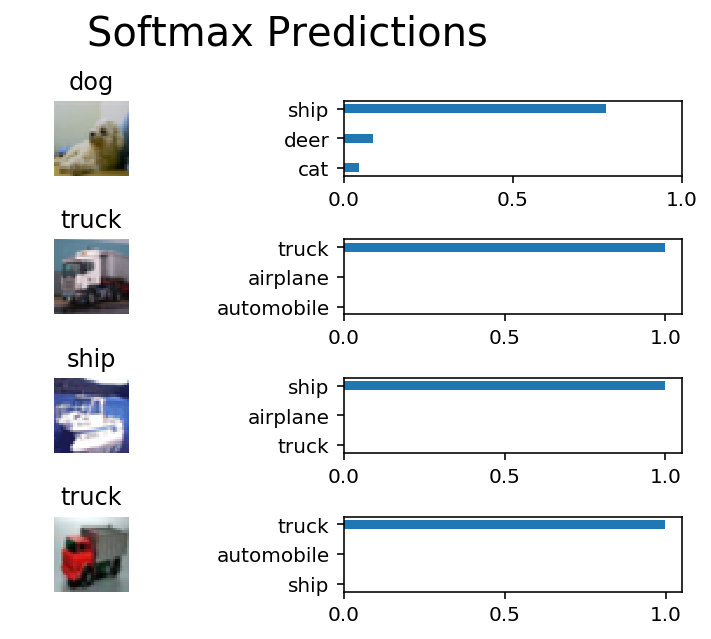

In [18]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size 
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()